In [8]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob
#For SVM
import scipy
import scipy.stats
from sklearn.svm import SVC

## Import Data

In [12]:

labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)

                index  crash_label        date  Quarter  000001.SS  ^BSESN  \
date                                                                         
1998-09-30  000001.SS            1  1998-09-30  Q3 1998        1.0     0.0   
1998-12-31  000001.SS            0  1998-12-31  Q4 1998        1.0     0.0   
1999-03-31  000001.SS            0  1999-03-31  Q1 1999        1.0     0.0   
1999-06-30  000001.SS            0  1999-06-30  Q2 1999        1.0     0.0   
1999-09-30  000001.SS            0  1999-09-30  Q3 1999        1.0     0.0   
...               ...          ...         ...      ...        ...     ...   
2018-12-31      ^SSMI            0  2018-12-31  Q4 2018        0.0     0.0   
2019-03-31      ^SSMI            0  2019-03-31  Q1 2019        0.0     0.0   
2019-06-30      ^SSMI            0  2019-06-30  Q2 2019        0.0     0.0   
2019-09-30      ^SSMI            0  2019-09-30  Q3 2019        0.0     0.0   
2019-12-31      ^SSMI            0  2019-12-31  Q4 2019        0

In [13]:
# Selected by eliminating 30% 0f features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', 'turnover_lag2', 'reserve_lag1', 'reserve_lag2',
       '10YGov_BondYield_lag1', '10YGov_BondYield_lag2',
       'current_acct_lag1', 'current_acct_lag2', 'FX_Rate_lag1',
       'turnover_lag1', 'Population_lag1', 'Gold_Price_lag2', 'npl_lag1',
       'npl_lag2', 'Recession_Indicators_lag1',
       'Recession_Indicators_lag2', 'inflation_lag1', 'inflation_lag2',
       'Unemployment_lag2', 'GDP_lag1', '^BSESN', 'housing_lag2',
       'volatility_lag1', 'volatility_lag2', '^BVSP', '^FCHI', '^FTLC',
       '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI', 'Gold_Price_lag1',
       'GDP_lag2', 'price_change_lag1', 'price_change_lag2',
       'volume_change_lag1', 'volume_change_lag2',
       'Crude_Oil_Index_Excess_Return_lag1',
       'Crude_Oil_Index_Excess_Return_lag2', 'Ted_Rate_lag1',
       'Ted_Rate_lag2']

# Build the model

In [65]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"C": [0.01, 0.05, 0.1, 1, 10, 100], 'gamma': ['scale','auto'], 'kernel': ['poly','rbf','sigmoid'], 'class_weight': ['balanced']}
        grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=tscv, scoring='f1', verbose=2, error_score=0)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
        
    # Train the model
    model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], class_weight=best_params['class_weight'], probability=True)
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    decision_values = model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, decision_values)
    fpr, tpr, thresholds = roc_curve(y_test, decision_values)
    
    
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_importance = np.abs(model.dual_coef_).sum(axis=0)
    for name, importance in zip(features_columns, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)        

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] 

[CV] END C=10, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV

[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.05, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf

prediction model trained
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=scale, kernel=sigmoid;

[CV] END C=10, class_weight=balanced, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=100, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=100, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=100, class_weight=balanced, gamma=scale, kernel=poly; total time=   0.0s

In [77]:
best_params_list

[{'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'sigmoid'},
 {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'},
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}]

In [81]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_SVM_selected_features.csv", index=False)
evaluation_df

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,Gold_Price_lag1_importance,GDP_lag2_importance,price_change_lag1_importance,price_change_lag2_importance,volume_change_lag1_importance,volume_change_lag2_importance,Crude_Oil_Index_Excess_Return_lag1_importance,Crude_Oil_Index_Excess_Return_lag2_importance,Ted_Rate_lag1_importance,Ted_Rate_lag2_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,[[51 17]\n [ 1 1]],0.055556,0.500000,0.100000,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.440643,10.0,10.0
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,[[23 19]\n [10 18]],0.486486,0.642857,0.553846,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.0,10.0
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,[[35 29]\n [ 5 1]],0.033333,0.166667,0.055556,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.100000,0.1,0.1
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,[[28 31]\n [ 8 3]],0.088235,0.272727,0.133333,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.100000,0.1,0.1
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,[[31 38]\n [ 0 1]],0.025641,1.000000,0.050000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.100000,0.1,0.1


## Shap Values

PermutationExplainer explainer: 71it [01:05,  1.10s/it]                       


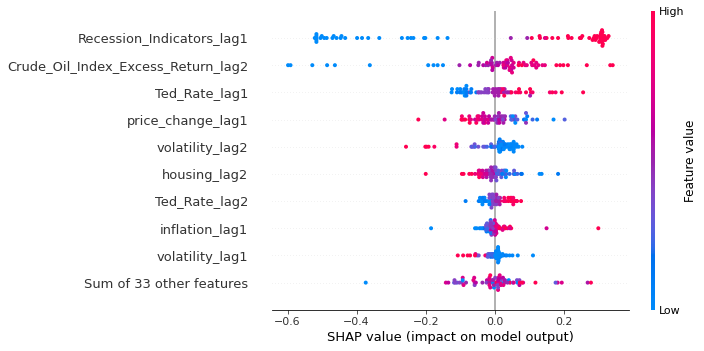

In [68]:
    
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# Feature Importance

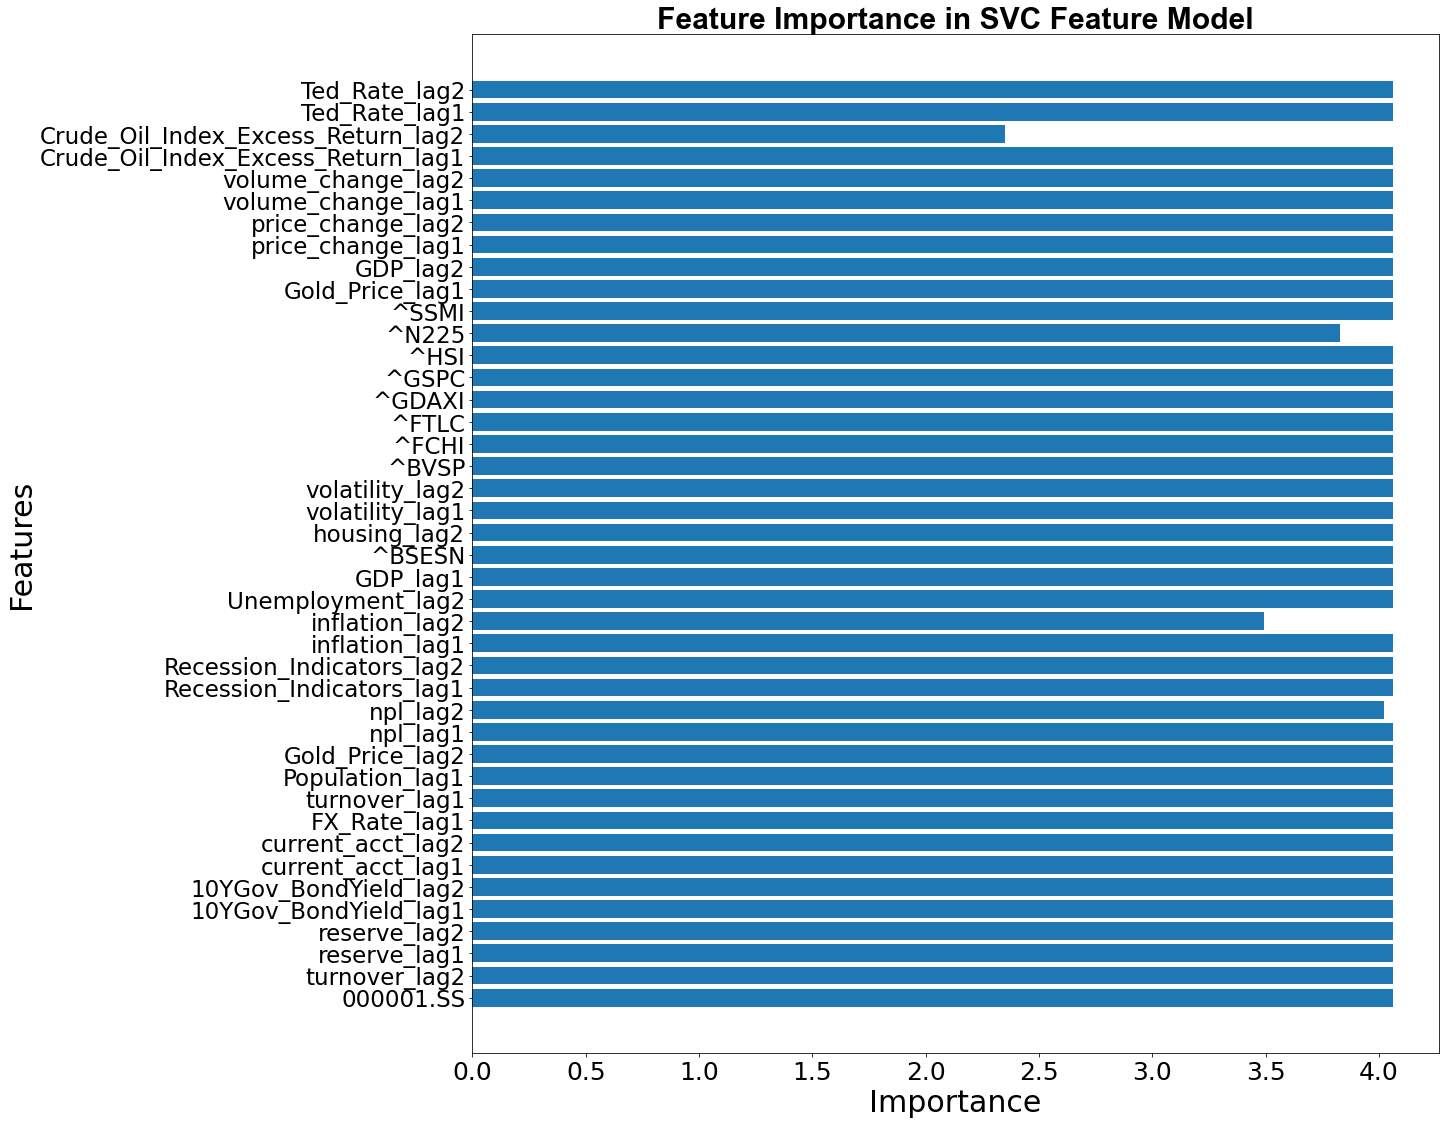

In [69]:
model_name = "SVC Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [70]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.4774367041483975


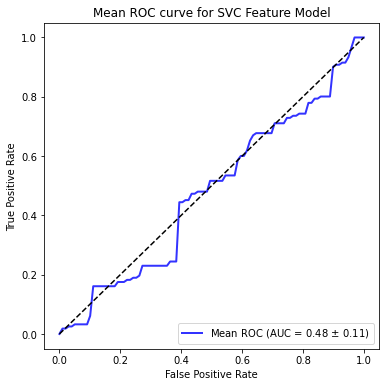

In [71]:
plot_roc_curve(evaluation_df, model_name)

# Vistualization

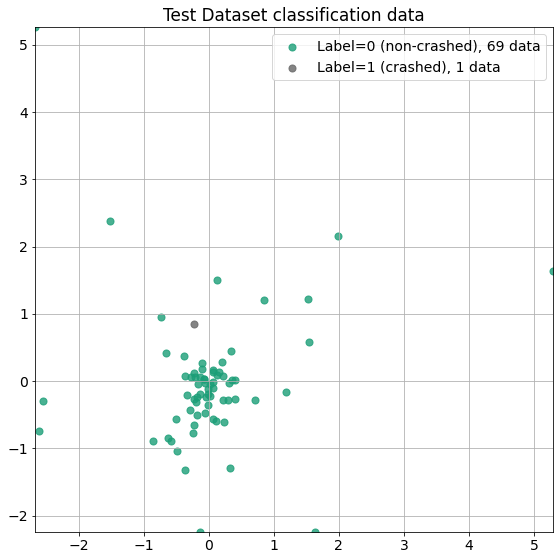

In [72]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

dx = X_test
dy = y_test
class_names = ['non-crashed','crashed']

classes, class_num = np.unique(dy, return_counts=True)
dx = PCA(n_components=2).fit_transform(dx)
dx = StandardScaler().fit_transform(dx)
dx_train, dx_test, dy_train, dy_test = \
    train_test_split(dx, dy, test_size=0.2, random_state=0)
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14
plt.title('Test Dataset classification data')

color = [cm.Dark2.colors[0], cm.Dark2.colors[-1]]
for label in classes:
    data = dx[dy==label]
    plt.scatter(*data.T, color=color[label], s=50, alpha=0.8,
                label=f'Label={label} ' + \
                      f'({class_names[label]}), ' + \
                      f'{class_num[label]} data')
plt.legend() 
plt.grid(True)
plt.xlim([np.amin(dx.T[0]), np.amax(dx.T[0])])
plt.ylim([np.amin(dx.T[1]), np.amax(dx.T[1])])
plt.tight_layout()
plt.show()

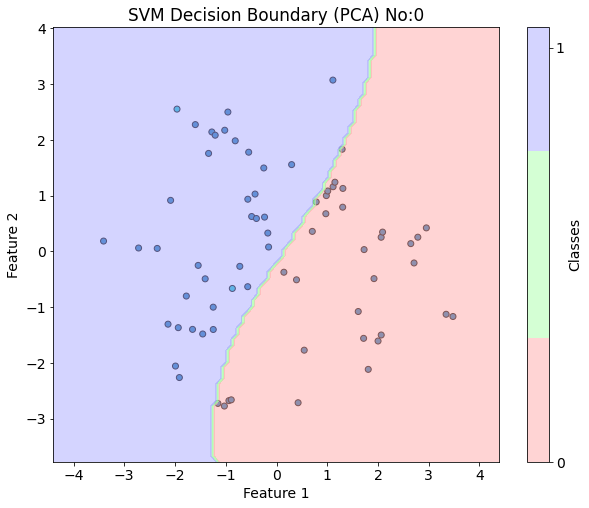

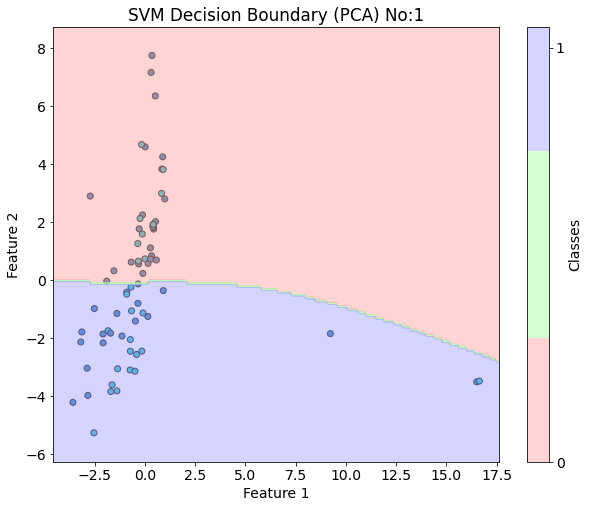

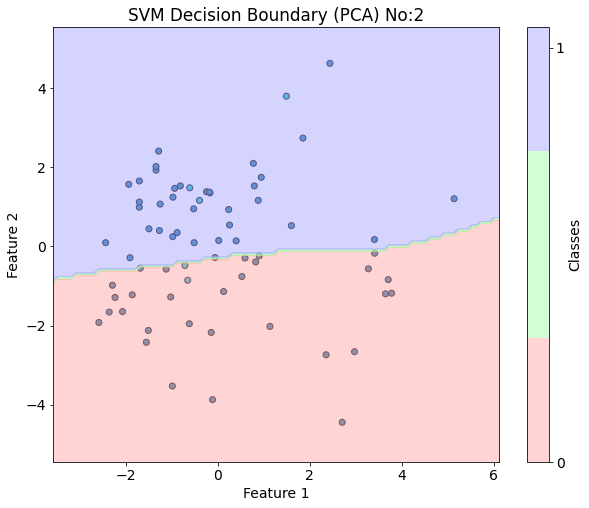

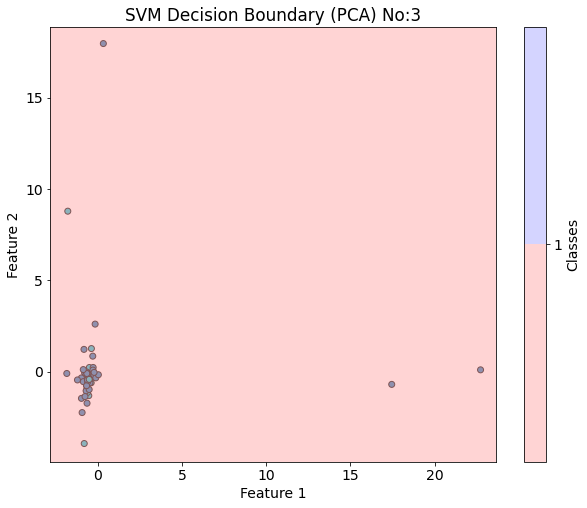

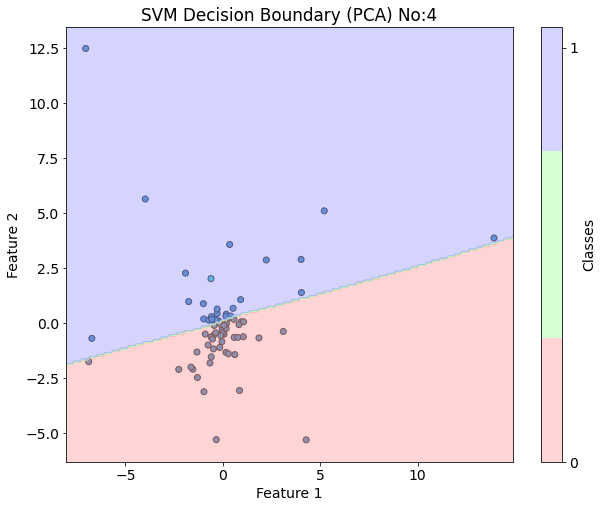

In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
i=0

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    best_params = best_params_list[-1]
    
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)

    # Train the SVM model
    model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], class_weight=best_params['class_weight'], probability=True)
    model.fit(X_pca, y_test)
    
    # Generate meshgrid for decision boundary visualization
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    XY = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(XY)

    # Reshape Z to have the same dimensions as xx and yy
    Z = Z.reshape(xx.shape)

    # Create a 2D scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab10', edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title('SVM Decision Boundary (PCA) No:'+ str(i))

    # Plot decision regions
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

    # Add colorbar legend
    classes = ['Class 0', 'Class 1', 'Class 2']
    bounds = [0, 1, 2, 3]
    plt.colorbar(ticks=bounds, label='Classes', boundaries=bounds, values=np.arange(3), ax=plt.gca())
    plt.show()
    
    i = i + 1

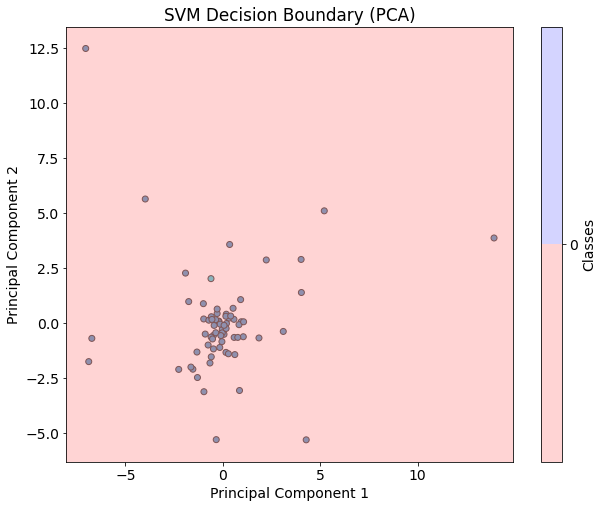

In [74]:


# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Train the SVM model
model = SVC(C=best_params['C'], gamma=best_params['gamma'], probability=True)
model.fit(X_pca, y_test)

# Generate meshgrid for decision boundary visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
XY = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(XY)

# Reshape Z to have the same dimensions as xx and yy
Z = Z.reshape(xx.shape)

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab10', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary (PCA)')

# Plot decision regions
cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

# Add colorbar legend
classes = ['Class 0', 'Class 1', 'Class 2']
bounds = [0, 1, 2, 3]
plt.colorbar(ticks=bounds, label='Classes', boundaries=bounds, values=np.arange(3), ax=plt.gca())
plt.show()